In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, algebra, quadrature
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import itertools
import time
import statistics as st
from pyiga import algebra_cy

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

Populating the interactive namespace from numpy and matplotlib


In [5]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]
deg=2

b = geometry.line_segment(np.array([0,1]),np.array([2,1])).as_nurbs()
t = geometry.line_segment(np.array([1,2]),np.array([2,2])).as_nurbs()
l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[0.,1.],[0.2,1.8],[1.,2.]]),weights = np.array([1.,1/sqrt(2),1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,1.5],[2,2]]), weights = np.array([1.,1.,1.]))
kvs_g2, coeffs_g2 = geometry._combine_boundary_curves(b,t,l,r)
geo2 = geometry.NurbsFunc(kvs_g2, coeffs_g2[:,:,:2], coeffs_g2[:,:,2].reshape(3,2), premultiplied=1)

l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,  1.5],[2,  2  ]]), weights = np.array([1.,1.,       1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3.5,1.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,1  ],[3,  1  ]]), weights = np.array([1.,1.,       1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,2],[2.5,2.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g3, coeffs_g3 = geometry._combine_boundary_curves(b,t,l,r)
coeffs_g3[1,1] = np.array([2.75,1.75,1.0])
geo3 = geometry.NurbsFunc(kvs_g3, coeffs_g3[:,:,:2], coeffs_g3[:,:,2], premultiplied=1)

l = geometry.line_segment(np.array([2,1]),np.array([3,1])).as_nurbs()
r = geometry.line_segment(np.array([2.5,-.5]),np.array([3,0])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,1],[2.5,0.5],[3,0]]),weights = np.array([1.,1.,1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3,0.5],[3.5,0.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g4, coeffs_g4 = geometry._combine_boundary_curves(b,t,l,r)
geo4 = geometry.NurbsFunc(kvs_g4, coeffs_g4[:,:,:2], coeffs_g4[:,:,2].reshape(2,3), premultiplied=1)

l = geometry.line_segment(np.array([2,0]),np.array([2,1])).as_nurbs()
r = geometry.line_segment(np.array([3,0]),np.array([3.5,0.5])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,0.],[2.5,0],[2.5,-.5]]),weights = np.array([1.,1/sqrt(2),1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,0.5],[3,0]]), weights = np.array([1.,1.,1.]))
kvs_g5, coeffs_g5 = geometry._combine_boundary_curves(b,t,l,r)
geo5 = geometry.NurbsFunc(kvs_g5, coeffs_g5[:,:,:2], coeffs_g5[:,:,2].reshape(2,3), premultiplied=1)


kvs=[(bspline.make_knots(deg,0.0,1.0,xN),bspline.make_knots(deg,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      # geometry.Quad(np.array([[0.,2.,1.,2.],
      #                         [1.,1.,2.,2.]])),
      geo2,
      geo3,
      # geometry.Quad(np.array([[2.,3.,2.,3.5],
      #                         [1.,1.,2.,2.5]])),
      geo4,
      # geometry.Quad(np.array([[2.,3.,3.,3.5],
      #                         [1.,0.,1.,0.5]])),
      geo5
     ]
      # geometry.Quad(np.array([[2.,2.5,2.,3.],
      #                         [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]

conn, interfaces = assemble.detect_interfaces(patches)
for i in range(len(interfaces)):
    (p1, bdspec1, p2, bdspec2, conn_info) = interfaces[i]
    interfaces[i] = ((p1, topology.bdspec_to_int(bdspec1), 0), (p2, topology.bdspec_to_int(bdspec2), 0), conn_info[1][0])

interfaces = interfaces + [
    ((2,0,0),(0,1,0),False),
    ((2,0,1),(1,1,0),False)
]

M = topology.PatchMesh(patches, interfaces)
MP = assemble.Multipatch(M, automatch=True)
#M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

setting up constraints took 0.010877132415771484 seconds.
1 took 2.6226043701171875e-06
1 took 9.5367431640625e-07
finding active constraints took 5.650520324707031e-05 seconds.
finding derived dofs took 0.0002639293670654297 seconds.
updating basis and constraints took 0.0045435428619384766 seconds.
main1 took 2.86102294921875e-06 seconds.
main2 took 0.0002307891845703125 seconds.
main3 took 0.000179290771484375 seconds.
Basis setup took 0.005588054656982422 seconds


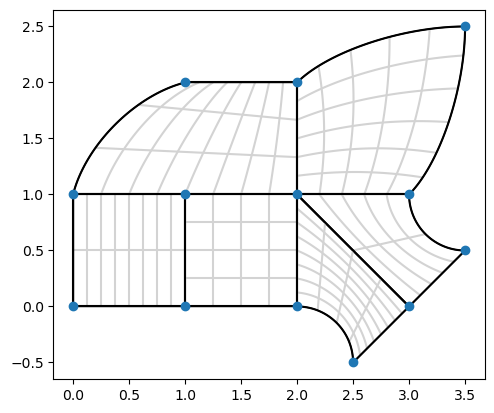

In [6]:
MP.mesh.draw(knots=1, nodes=1, patch_idx=0)

In [7]:
for i in range(9):
    MP.h_refine(-1)
    print(MP.numdofs)

Refinement took 0.0013756752014160156 seconds for 6 patches.
setting up constraints took 0.01469731330871582 seconds.
1 took 4.291534423828125e-06
1 took 1.1920928955078125e-06
finding active constraints took 8.58306884765625e-05 seconds.
finding derived dofs took 0.0004405975341796875 seconds.
updating basis and constraints took 0.005379676818847656 seconds.
main1 took 4.5299530029296875e-06 seconds.
main2 took 0.0002512931823730469 seconds.
main3 took 0.00022172927856445312 seconds.
Basis setup took 0.006753444671630859 seconds
682
Refinement took 0.00025773048400878906 seconds for 6 patches.
setting up constraints took 0.014700651168823242 seconds.
1 took 6.4373016357421875e-06
1 took 1.430511474609375e-06
finding active constraints took 0.00013685226440429688 seconds.
finding derived dofs took 0.0008382797241210938 seconds.
updating basis and constraints took 0.005503654479980469 seconds.
main1 took 6.9141387939453125e-06 seconds.
main2 took 0.00025463104248046875 seconds.
main3 to

In [7]:
active = np.arange(MP.Constr.shape[0])
%timeit algebra_cy.pyx_find_ddofs(MP.Constr, active)
%timeit algebra.find_ddofs(MP.Constr, active)

15.8 ms ± 797 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
87.1 ms ± 902 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
ddofs = algebra_cy.pyx_find_ddofs(MP.Constr, active)
%timeit algebra_cy.pyx_update_basis(MP.Constr, ddofs, scipy.sparse.identity(MP.N_ofs[-1]).tocsc())
%timeit algebra.update_basis(MP.Constr, ddofs, scipy.sparse.identity(MP.N_ofs[-1]).tocsc())

3.45 s ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.13 s ± 6.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
Basis = algebra_cy.pyx_update_basis(MP.Constr, ddofs, scipy.sparse.identity(MP.N_ofs[-1]))
Constr = MP.Constr @ Basis
%timeit algebra_cy.pyx_compute_active_constr(Constr)
%timeit algebra.compute_active_constr(Constr)

1.76 ms ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.91 ms ± 8.38 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit algebra_cy.pyx_compute_basis(MP.Constr, maxiter=10)
%timeit algebra.compute_basis(MP.Constr, maxiter=10)

7.75 s ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
